In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', 999)
pd.set_option('max_columns',100)
pd.set_option('max_rows',10000)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
train = pd.read_csv('c:/Users/Yunki/DataQuest/MyDataSet/train.csv')
test = pd.read_csv('c:/Users/Yunki/DataQuest/MyDataSet/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5000,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0000,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0000,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0000,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0000,1,1,3101298,12.2875,NaN,S


In [4]:
# %load kaggle_functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
def process_data(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    for i in cols:
        df = create_dummies(df,i)
    return df

In [6]:
train = process_data(train)
test = process_data(test)

In [7]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


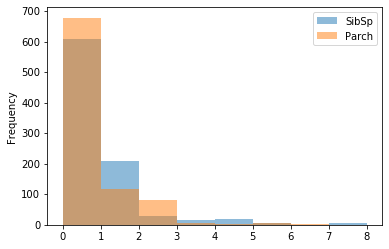

In [8]:
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

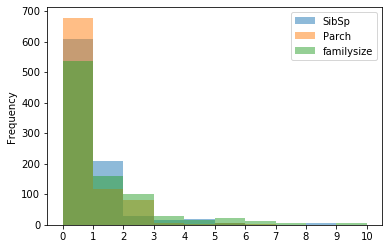

In [9]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

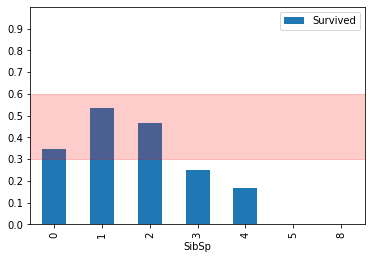

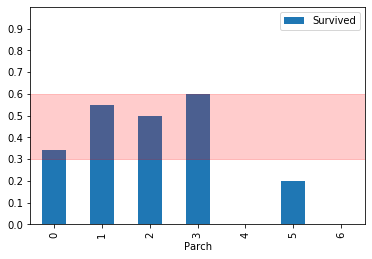

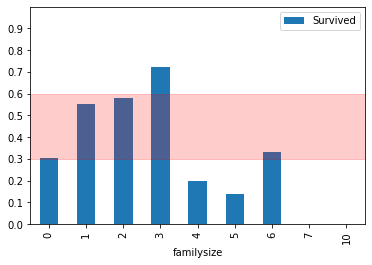

In [10]:
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

In [11]:
def isalone_process(row):
    return 1 if row[["SibSp","Parch"]].sum() == 0 else 0

train['isalone'] = train.apply(isalone_process,axis= 1)
test['isalone'] = test.apply(isalone_process,axis = 1)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    df = df.select_dtypes(['float64','int64','uint8'])
    df = df.dropna(axis =1)
    all_X = df.drop(['Survived','PassengerId'],axis=1)
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf,cv=10)
    selector.fit(all_X,all_y)
    optimized_features = all_X.columns[selector.support_]
    return optimized_features

In [13]:
best_features = select_features(train)
best_features

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')

In [14]:
import model_prep as mp
sel_feat = mp.ModelPrepSelectFeatures(train).collin()

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
def model_selection(df,features):
    all_X = df[features]
    all_y = df['Survived']
    model_search = [
        {
            'name':'LogisticRegression',
            'estimator':LogisticRegression(),
            'hyperparameters':
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            'name':'KNeighborsClassifier',
            'estimator':KNeighborsClassifier(),
            'hyperparameters':
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            'name':'RandomForestClassifier',
            'estimator':RandomForestClassifier(),
            'hyperparameters':
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    for d in model_search:
        print(f"model search: {d['name']}")
        model = d['estimator']
        grid = GridSearchCV(model,param_grid=d['hyperparameters'],cv=10)
        grid.fit(all_X,all_y)
        d['best_params'] = grid.best_params_
        d['best_score'] = grid.best_score_
        d['best_estimator'] = grid.best_estimator_
        print(f"best parameter: {d['best_params']}")
        print(f"best score: {d['best_score']}")
    return model_search

In [16]:
model_selected = model_selection(train,best_features)
model_selected

model search: LogisticRegression
best parameter: {'solver': 'liblinear'}
best score: 0.8204264870931538
model search: KNeighborsClassifier
best parameter: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
best score: 0.7755331088664422
model search: RandomForestClassifier
best parameter: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
best score: 0.8395061728395061


C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'best_params': {'solver': 'liblinear'},
  'best_score': 0.8204264870931538,
  'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                     warm_start=False)},
 {'name': 'KNeighborsClassifier',
  'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='m

In [17]:
best_features_1 = best_features.drop(['Sex_female','Sex_male'])
model_selected = model_selection(train,best_features_1)
model_selected

model search: LogisticRegression
best parameter: {'solver': 'liblinear'}
best score: 0.8204264870931538
model search: KNeighborsClassifier
best parameter: {'algorithm': 'brute', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
best score: 0.7598204264870931
model search: RandomForestClassifier
best parameter: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}
best score: 0.8361391694725028


C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Yunki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'best_params': {'solver': 'liblinear'},
  'best_score': 0.8204264870931538,
  'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                     warm_start=False)},
 {'name': 'KNeighborsClassifier',
  'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='m

In [18]:
def save_submission_file(model,features,df):
    holdout = df[features]
    prediction = best_model.predict(holdout)
    submission = pd.DataFrame({'PassengerId':df['PassengerId'],'Survived':prediction})
    submission.to_csv('c:/Users/Yunki/DataQuest/kaggle_submission.csv', index=False)

In [19]:
best_model = model_selected[2]['best_estimator']
save_submission_file(best_model,best_features_1,test)

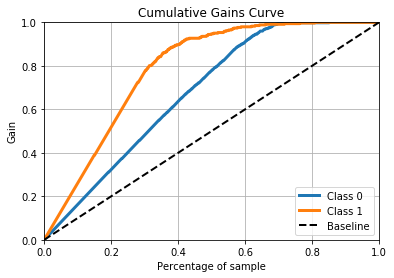

In [20]:
import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline
y_probas = best_model.predict_proba(train[best_features_1])
skplt.metrics.plot_cumulative_gain(train['Survived'], y_probas)